In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/My Drive/test-hometask

/content/gdrive/My Drive/test-hometask


In [ ]:
! git clone https://github.com/alienspaceman/test-task.git

Cloning into 'test-task'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 107 (delta 30), reused 97 (delta 22), pack-reused 0
Receiving objects: 100% (107/107), 10.53 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [ ]:
%cd test-task/

/content/gdrive/My Drive/test-hometask/test-task


In [ ]:
!git pull

Already up to date.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from utils import preprocessing_utils, general_utils

Load datasets: train, test, store

In [ ]:
DATA_PATH = 'data/'

In [ ]:
train_df = pd.read_csv(DATA_PATH + 'train.csv', low_memory=False)
test_df = pd.read_csv(DATA_PATH + 'test.csv', low_memory=False)
store_df = pd.read_csv(DATA_PATH + 'store.csv')

In [ ]:
train_df['Date'] = pd.to_datetime(train_df['Date'], infer_datetime_format=True)
test_df['Date'] = pd.to_datetime(test_df['Date'], infer_datetime_format=True)

In [ ]:
print(train_df['Date'].min(), train_df['Date'].max())
print(test_df['Date'].min(), test_df['Date'].max())

2013-01-01 00:00:00 2015-07-31 00:00:00
2015-08-01 00:00:00 2015-09-17 00:00:00


We have data 2013, 2014 and 2015 till 2015-07-31. \
We need to predict sales for the next 1,5 month i.e. 47 days.

## Data Preparation

Fill missing values

In [ ]:
test_df['Open'] = test_df.groupby('Store')['Open'].ffill()
test_df['Open'].fillna(0, inplace=True)

In [ ]:
test_df.isna().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Remove records for the dates when stores were closed. \

1. Select indeces of records for the dates when stores were closed.
2. Save information about promos and holidays on that dates.
3. Fill the gaps in date range
3. Fill the gaps in sales and customers values by interpolation
4. Fill missing values in promos and holidays from the previously saved data where it's possible
5. Fill left missing values with the nearest values

In [ ]:
train_df = preprocessing_utils.interpolate_sales_customers(train_df, method='nearest')

2021-02-25 23:40:11,946 | INFO : Shape before removal: (1017209, 9)
2021-02-25 23:40:12,292 | INFO : Shape after removal: (844392, 9)
2021-02-25 23:40:15,110 | INFO : Shape after filling date gaps: (1048712, 9)
2021-02-25 23:40:18,303 | INFO : Number of missing values in df: 0


In [ ]:
train_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-02,1,3.0,5530.0,668.0,1.0,0.0,0,1.0
1,2013-01-03,1,4.0,4327.0,578.0,1.0,0.0,0,1.0
2,2013-01-04,1,5.0,4486.0,619.0,1.0,0.0,0,1.0
3,2013-01-05,1,6.0,4997.0,635.0,1.0,0.0,0,1.0
4,2013-01-06,1,6.0,4997.0,635.0,0.0,0.0,0,1.0


### Preprocess store data

In [ ]:
store_df = preprocessing_utils.fill_nans_store_df(store_df)

2021-02-25 23:40:18,409 | INFO : Fill NaN in CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear with 0
2021-02-25 23:40:18,411 | INFO : Fill NaN in Promo2SinceWeek, Promo2SinceYear with 0
2021-02-25 23:40:18,413 | INFO : Fill NaN in PromoInterval with ""


In [ ]:
DATA_PATH = 'largefiles/'

In [ ]:
store_df, store_label_encoder = preprocessing_utils.transform_store_df(store_df, DATA_PATH + 'store_cat_cols_le')

2021-02-25 23:40:18,488 | INFO : Encode labels in ['StoreType', 'Assortment', 'PromoInterval']
2021-02-25 23:40:18,493 | INFO : Transform log1p CompetitionDistance
2021-02-25 23:40:18,495 | INFO : Transform date features
2021-02-25 23:40:18,502 | INFO : Save label encoder to largefiles/store_cat_cols_le.pkl


In [ ]:
store_label_encoder

{'Assortment': {'a': 0, 'b': 1, 'c': 2},
 'PromoInterval': {'': 0,
  'Feb,May,Aug,Nov': 1,
  'Jan,Apr,Jul,Oct': 2,
  'Mar,Jun,Sept,Dec': 3},
 'StoreType': {'a': 0, 'b': 1, 'c': 2, 'd': 3}}

### Preprocess train/test

In [ ]:
test_df['Sales'] = np.nan
test_df['Customers'] = np.nan
sales_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
train_df['StateHoliday'].unique()

array(['0', 'b', 'a', 'c'], dtype=object)

In [ ]:
sales_df, sales_label_encoder = preprocessing_utils.transform_sales_df(sales_df, DATA_PATH + 'sales_cat_cols_le')

2021-02-25 23:40:18,745 | INFO : Add Day, Month, Year features
2021-02-25 23:40:19,053 | INFO : Transform date features
2021-02-25 23:40:19,597 | INFO : Encode StateHoliday
2021-02-25 23:40:19,598 | INFO : Encode labels in ['StateHoliday']
2021-02-25 23:40:19,751 | INFO : Save label encoder to largefiles/sales_cat_cols_le.pkl


In [ ]:
data = sales_df.merge(store_df, on='Store', how='left')

In [ ]:
data.drop(['Year', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Id'], axis=1, inplace=True)

In [ ]:
data.shape

(1089800, 23)

In [ ]:
data.isna().sum()

Date                                 0
Store                                0
Sales                            41088
Customers                        41088
Open                                 0
Promo                                0
StateHoliday                         0
SchoolHoliday                        0
DayOfWeek_sin                        0
DayOfWeek_cos                        0
Month_sin                            0
Month_cos                            0
Day_sin                              0
Day_cos                              0
StoreType                            0
Assortment                           0
CompetitionDistance                  0
Promo2                               0
PromoInterval                        0
CompetitionOpenSinceMonth_sin        0
CompetitionOpenSinceMonth_cos        0
Promo2SinceWeek_sin                  0
Promo2SinceWeek_cos                  0
dtype: int64

In [ ]:
data.to_pickle(DATA_PATH + 'unscaled_sales_data.pickle')

In [ ]:
from utils.general_utils import open_pickle_file

In [ ]:
data = open_pickle_file(DATA_PATH + 'unscaled_sales_data')

## Prepare data for model training

Validation strategy: Side-by-side split\
Dataset splits into independent parts, one part used strictly for training and another part used strictly for validation.

Data range 2013 to 2015-07-31. \
Validation Model is trained on 2013 to 2015 data and predict 47 days of 2015 data.
The best performing model will be trained on 2013 to 2015-07-31 data to predict 47 days from 2015-08-01 without validation. \

In the validation model sequences of the last 47 days of 2014 shouldn't be included because it contains 2015 values in y.

In [ ]:
data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
data['Date'].max()

Timestamp('2015-09-17 00:00:00')

In [ ]:
full_range = pd.date_range(data['Date'].min(), data['Date'].max())

In [ ]:
full_range[full_range<'2014-11-15']

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2014-11-05', '2014-11-06', '2014-11-07', '2014-11-08',
               '2014-11-09', '2014-11-10', '2014-11-11', '2014-11-12',
               '2014-11-13', '2014-11-14'],
              dtype='datetime64[ns]', length=683, freq='D')

### Normalize Data

In [ ]:
cols_to_scale = {'td': ['Sales', 'Customers'],
                 'ti': ['Assortment', 'CompetitionDistance']
                }
val_date = None
mode = 'val'
if mode == 'val':
    val_date = '2014-11-15'

In [ ]:
scaled_data, scale_map = preprocessing_utils.scale_data(data,
                                                        DATA_PATH + f'scalemap',
                                                        DATA_PATH + f'scaled_data_{mode}',
                                                        cols_to_scale,
                                                        mode=mode,
                                                        val_date=val_date
                                                       )

2021-02-25 23:40:25,303 | INFO : Log Transform Sales and Customers
2021-02-25 23:40:25,354 | INFO : Select records for scaler fitting
2021-02-25 23:40:25,410 | INFO : Start scaling time-dependant features ['Sales', 'Customers']



  0%|          | 0/1115 [00:00<?, ?it/s]


  0%|          | 3/1115 [00:00<00:38, 28.67it/s]


  1%|▏         | 14/1115 [00:00<00:30, 36.63it/s]


  2%|▏         | 23/1115 [00:00<00:24, 44.28it/s]


  3%|▎         | 31/1115 [00:00<00:21, 49.91it/s]


  3%|▎         | 38/1115 [00:00<00:20, 53.49it/s]


  4%|▍         | 44/1115 [00:00<00:19, 54.47it/s]


  4%|▍         | 50/1115 [00:00<00:19, 54.19it/s]


  5%|▌         | 56/1115 [00:00<00:20, 52.54it/s]


  6%|▌         | 62/1115 [00:01<00:20, 50.47it/s]


  6%|▌         | 68/1115 [00:01<00:22, 47.11it/s]


  7%|▋         | 73/1115 [00:01<00:23, 44.40it/s]


  7%|▋         | 78/1115 [00:01<00:24, 42.64it/s]


  7%|▋         | 83/1115 [00:01<00:25, 41.24it/s]


  8%|▊         | 88/1115 [00:01<00:26, 39.23it/s]



Mem. usage decreased to 58.20 Mb (74.1% reduction)


In [ ]:
scale_map.keys()

dict_keys(['Sales', 'Customers', 'Assortment', 'CompetitionDistance'])

In [ ]:
scale_map['Sales']

{1: {'mean': 8.451875648839263, 'std': 0.19393253966210106},
 2: {'mean': 8.368323252370194, 'std': 0.36491517170729176},
 3: {'mean': 8.729891495772316, 'std': 0.3417506321175818},
 4: {'mean': 9.14869205715302, 'std': 0.1838227981209564},
 5: {'mean': 8.25347856423719, 'std': 0.4794285235826549},
 6: {'mean': 8.55375589543737, 'std': 0.31566521989458557},
 7: {'mean': 8.982638445938417, 'std': 0.29682242067413195},
 8: {'mean': 8.413938959594347, 'std': 0.4062706963083678},
 9: {'mean': 8.698446806012095, 'std': 0.21241408104535603},
 10: {'mean': 8.567449011258896, 'std': 0.17843351323251735},
 11: {'mean': 8.924986304143246, 'std': 0.24502965430679013},
 12: {'mean': 8.8556848469279, 'std': 0.2428844756175326},
 13: {'mean': 8.539991664608591, 'std': 0.3570113862427135},
 14: {'mean': 8.510776985226967, 'std': 0.2990950924736541},
 15: {'mean': 8.740979958046236, 'std': 0.22123011291605077},
 16: {'mean': 8.842044627691443, 'std': 0.26405059923132423},
 17: {'mean': 8.5576147731072

In [ ]:
len(scale_map['Sales'])

1115

In [ ]:
len(scale_map['Assortment'])

2

### Build data sequences

In [ ]:
scaled_data.columns

Index(['Date', 'Store', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'Day_sin', 'Day_cos', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval',
       'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos',
       'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos', 'Sales_mean',
       'Customers_mean', 'Assortment_mean', 'CompetitionDistance_mean'],
      dtype='object')

In [ ]:
n_steps_in = 120
input_data_filename = DATA_PATH + f'scaled_data_{mode}'
output_data_filename = DATA_PATH + f'sequence_data_{mode}'

In [ ]:
input_data_filename

'largefiles/scaled_data_val'

In [ ]:
output_data_filename

'largefiles/sequence_data_val'

In [ ]:
!pip install "tqdm==4.43.0"

In [ ]:
! python build_sequence.py 'largefiles/scaled_data_val' 'largefiles/sequence_data_val' 120

0it [00:00, ?it/s]
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
2021-02-25 23:43:41,254 | INFO : largefiles/scaled_data_val
2021-02-25 23:43:41,254 | INFO : Time-dependant features: ['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']
2021-02-25 23:43:41,254 | INFO : Time-independent features: ['Date', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'PromoInterval', 'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos', 'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos']
2021-02-25 23:43:41,255 | INFO : Target Feature: Sales
2021-02-25 23:43:41,255 | INFO : Load pickle file: largefiles/scaled_data_val
2021-02-25 23:43:41,355 | INFO : Start building sequences
100% 185/185 [23:59<00:00,  7.78s/it]


In [ ]:
seq_data = general_utils.open_pickle_file(output_data_filename)

### Prepare pytorch dataloader

In [ ]:
from utils.preprocessing_utils import StoreDataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
val_date

'2014-11-15'

In [ ]:
pd.to_datetime('2013-04-01') - pd.to_datetime('2013-01-01')

Timedelta('90 days 00:00:00')

In [ ]:
test_sequence_data = seq_data[seq_data['Date'] == '2015-08-01']

In [ ]:
if mode == 'val':
    train_sequence_data = seq_data[(seq_data['Date'] >= '2013-04-01') & (seq_data['Date'] <= val_date)]
    valid_sequence_data = seq_data[(seq_data['Date'] > val_date) & (seq_data['Date'] <= '2015-01-01')]
else:    
    train_sequence_data = seq_data[(seq_data['Date'] >= '2013-04-01') & (seq_data['Date'] <= '2015-07-31') ]
    valid_sequence_data = pd.DataFrame()

In [ ]:
print(train_sequence_data.shape, valid_sequence_data.shape, test_sequence_data.shape)

(627279, 13) (52405, 13) (856, 13)


In [ ]:
cat_columns = ['StoreType', 'Promo2', 'PromoInterval']
num_columns = ['CompetitionDistance', 'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos',
               'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos', 
#                'Sales_mean',
#                'Customers_mean', 'Assortment_mean', 'CompetitionDistance_mean'
              ]

In [ ]:
train_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True )
valid_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True )
test_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True)

2021-02-26 00:11:32,428 | INFO : Create Dataset object
2021-02-26 00:11:32,429 | INFO : Create Dataset object
2021-02-26 00:11:32,430 | INFO : Create Dataset object


In [ ]:
train_dataset.load_sequence_data(train_sequence_data)
valid_dataset.load_sequence_data(valid_sequence_data)
test_dataset.load_sequence_data(test_sequence_data)

2021-02-26 00:11:34,536 | INFO : Load data
2021-02-26 00:11:34,538 | INFO : Load data
2021-02-26 00:11:34,539 | INFO : Load data


In [ ]:
train_dataset.process_cat_columns()

In [ ]:
valid_dataset.process_cat_columns()

In [ ]:
test_dataset.process_cat_columns()

In [ ]:
len_cat = {'le': len(num_columns), 'ohe' : sum([x for x in zip(*train_dataset.cat_embed_shape)][0])}

In [ ]:
12 + len(num_columns) + len_cat['ohe']

27

In [ ]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(valid_dataloader))

2451 205


In [ ]:
X, y = next(iter(train_dataloader))
print(len(X))
print(X[0].shape)

256
torch.Size([120, 27])


In [ ]:
y.shape

torch.Size([256, 47])

### Create model

In [ ]:
!pip install torch_lr_finder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils.model_utils import RNNEncoder, DecoderCell, EncoderDecoderWrapper, TorchTrainer
device = 'cuda'

encoder = RNNEncoder(
    input_feature_len=train_dataset[0][0].shape[1], 
    rnn_num_layers=16, 
    hidden_size=128,  
    sequence_len=train_dataset[0][0].shape[0],
    bidirectional=False,
    device=device,
    rnn_dropout=0.1
)

decoder_cell = DecoderCell(
    input_feature_len=1,
    hidden_size=128,
)


loss_function = nn.MSELoss()



encoder = encoder.to(device)
decoder_cell = decoder_cell.to(device)

model = EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size=train_dataset[0][1].shape[0],
    teacher_forcing=0,
    sequence_len=train_dataset[0][0].shape[0],
    decoder_input=False,
    device='cuda'
)

model = model.to(device)

encoder_optimizer = optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-2)
decoder_optimizer = optim.AdamW(decoder_cell.parameters(), lr=1e-3, weight_decay=1e-2)

encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)
decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)

model_optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

In [ ]:
trainer = TorchTrainer(
    'encoder_decoder_120_47_adam_model_2ep',
    model, 
    [encoder_optimizer, decoder_optimizer], 
    loss_function, 
    [encoder_scheduler, decoder_scheduler],
    device, 
    scheduler_batch_step=True,
    pass_y=True
)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.94E-03


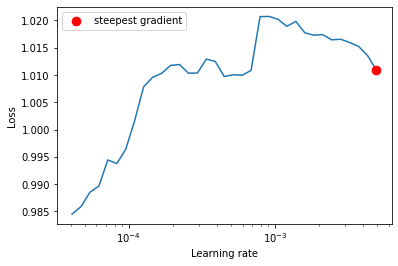

In [ ]:
trainer.lr_find(train_dataloader, model_optimizer, start_lr=1e-5, end_lr=1e-2, num_iter=50)

In [ ]:
vd = valid_dataloader if mode == 'val' else None
trainer.train(2, train_dataloader, vd, resume_only_model=True, resume=True)

Выходные данные были обрезаны до нескольких последних строк (5000).



loss 0.8888:  75%|███████▍  | 1827/2451 [20:47<07:07,  1.46it/s]



loss 0.8888:  75%|███████▍  | 1828/2451 [20:47<07:05,  1.46it/s]



loss 0.9377:  75%|███████▍  | 1828/2451 [20:48<07:05,  1.46it/s]



loss 0.9377:  75%|███████▍  | 1829/2451 [20:48<07:04,  1.47it/s]



loss 0.9262:  75%|███████▍  | 1829/2451 [20:49<07:04,  1.47it/s]



loss 0.9262:  75%|███████▍  | 1830/2451 [20:49<07:03,  1.47it/s]



loss 0.9124:  75%|███████▍  | 1830/2451 [20:49<07:03,  1.47it/s]



loss 0.9124:  75%|███████▍  | 1831/2451 [20:49<07:02,  1.47it/s]



loss 0.9010:  75%|███████▍  | 1831/2451 [20:50<07:02,  1.47it/s]



loss 0.9010:  75%|███████▍  | 1832/2451 [20:50<07:02,  1.47it/s]



loss 0.8736:  75%|███████▍  | 1832/2451 [20:51<07:02,  1.47it/s]



loss 0.8736:  75%|███████▍  | 1833/2451 [20:51<07:03,  1.46it/s]



loss 0.8689:  75%|███████▍  | 1833/2451 [20:51<07:03,  1.46it/s]



loss 0.8689:  75%|███████▍  | 1834/2451 [20:5

Training loss at epoch 1 - 0.958250840306282






  0%|          | 1/205 [00:00<01:18,  2.60it/s]



  1%|          | 2/205 [00:00<01:16,  2.64it/s]



  1%|▏         | 3/205 [00:01<01:15,  2.68it/s]



  2%|▏         | 4/205 [00:01<01:14,  2.70it/s]



  2%|▏         | 5/205 [00:01<01:13,  2.70it/s]



  3%|▎         | 6/205 [00:02<01:13,  2.72it/s]



  3%|▎         | 7/205 [00:02<01:12,  2.74it/s]



  4%|▍         | 8/205 [00:02<01:11,  2.75it/s]



  4%|▍         | 9/205 [00:03<01:22,  2.38it/s]



  5%|▍         | 10/205 [00:03<01:19,  2.46it/s]



  5%|▌         | 11/205 [00:04<01:15,  2.55it/s]



  6%|▌         | 12/205 [00:04<01:13,  2.61it/s]



  6%|▋         | 13/205 [00:04<01:12,  2.66it/s]



  7%|▋         | 14/205 [00:05<01:10,  2.71it/s]



  7%|▋         | 15/205 [00:05<01:09,  2.72it/s]



  8%|▊         | 16/205 [00:06<01:08,  2.75it/s]



  8%|▊         | 17/205 [00:06<01:08,  2.75it/s]



  9%|▉         | 18/205 [00:06<01:07,  2.75it/s]



  9%|▉         | 19/205 [00:07<01:07,  2.75it/s]



 10%|▉         | 

{}
Valid loss at epoch 1 - 1.4484805089671438
saved checkpoint for epoch 1


Выходные данные были обрезаны до нескольких последних строк (5000).



loss 0.9184:  75%|███████▍  | 1827/2451 [20:55<07:11,  1.44it/s]



loss 0.9184:  75%|███████▍  | 1828/2451 [20:55<07:10,  1.45it/s]



loss 0.8905:  75%|███████▍  | 1828/2451 [20:56<07:10,  1.45it/s]



loss 0.8905:  75%|███████▍  | 1829/2451 [20:56<07:08,  1.45it/s]



loss 0.9084:  75%|███████▍  | 1829/2451 [20:57<07:08,  1.45it/s]



loss 0.9084:  75%|███████▍  | 1830/2451 [20:57<07:05,  1.46it/s]



loss 0.9611:  75%|███████▍  | 1830/2451 [20:57<07:05,  1.46it/s]



loss 0.9611:  75%|███████▍  | 1831/2451 [20:57<07:05,  1.46it/s]



loss 0.9695:  75%|███████▍  | 1831/2451 [20:58<07:05,  1.46it/s]



loss 0.9695:  75%|███████▍  | 1832/2451 [20:58<07:05,  1.45it/s]



loss 0.9448:  75%|███████▍  | 1832/2451 [20:59<07:05,  1.45it/s]



loss 0.9448:  75%|███████▍  | 1833/2451 [20:59<07:05,  1.45it/s]



loss 0.9189:  75%|███████▍  | 1833/2451 [20:59<07:05,  1.45it/s]



loss 0.9189:  75%|███████▍  | 1834/2451 [20:5

Training loss at epoch 2 - 0.9342637060582638






  0%|          | 1/205 [00:00<01:18,  2.59it/s]



  1%|          | 2/205 [00:00<01:16,  2.65it/s]



  1%|▏         | 3/205 [00:01<01:15,  2.69it/s]



  2%|▏         | 4/205 [00:01<01:13,  2.72it/s]



  2%|▏         | 5/205 [00:01<01:13,  2.72it/s]



  3%|▎         | 6/205 [00:02<01:13,  2.72it/s]



  3%|▎         | 7/205 [00:02<01:12,  2.74it/s]



  4%|▍         | 8/205 [00:02<01:12,  2.73it/s]



  4%|▍         | 9/205 [00:03<01:12,  2.70it/s]



  5%|▍         | 10/205 [00:03<01:12,  2.71it/s]



  5%|▌         | 11/205 [00:04<01:11,  2.73it/s]



  6%|▌         | 12/205 [00:04<01:10,  2.73it/s]



  6%|▋         | 13/205 [00:04<01:10,  2.73it/s]



  7%|▋         | 14/205 [00:05<01:10,  2.72it/s]



  7%|▋         | 15/205 [00:05<01:10,  2.71it/s]



  8%|▊         | 16/205 [00:05<01:09,  2.72it/s]



  8%|▊         | 17/205 [00:06<01:08,  2.73it/s]



  9%|▉         | 18/205 [00:06<01:07,  2.75it/s]



  9%|▉         | 19/205 [00:06<01:07,  2.75it/s]



 10%|▉         | 

{}
Valid loss at epoch 2 - 1.4237589748894297
saved checkpoint for epoch 2


In [ ]:
trainer._load_checkpoint(only_model=True)

loaded checkpoint for epoch - 2


2

In [ ]:
if mode == 'val':
    valid_predictions = trainer.predict(valid_dataloader)




  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:11,  2.84it/s]


  1%|          | 2/205 [00:00<01:12,  2.80it/s]


  1%|▏         | 3/205 [00:01<01:12,  2.78it/s]


  2%|▏         | 4/205 [00:01<01:12,  2.78it/s]


  2%|▏         | 5/205 [00:01<01:11,  2.78it/s]


  3%|▎         | 6/205 [00:02<01:11,  2.79it/s]


  3%|▎         | 7/205 [00:02<01:10,  2.79it/s]


  4%|▍         | 8/205 [00:02<01:11,  2.75it/s]


  4%|▍         | 9/205 [00:03<01:12,  2.72it/s]


  5%|▍         | 10/205 [00:03<01:11,  2.72it/s]


  5%|▌         | 11/205 [00:04<01:11,  2.71it/s]


  6%|▌         | 12/205 [00:04<01:10,  2.73it/s]


  6%|▋         | 13/205 [00:04<01:09,  2.77it/s]


  7%|▋         | 14/205 [00:05<01:09,  2.76it/s]


  7%|▋         | 15/205 [00:05<01:08,  2.77it/s]


  8%|▊         | 16/205 [00:05<01:08,  2.77it/s]


  8%|▊         | 17/205 [00:06<01:08,  2.75it/s]


  9%|▉         | 18/205 [00:06<01:07,  2.75it/s]


  9%|▉         | 19/205 [00:06<01:07,  2.76it/

In [ ]:
test_predictions = trainer.predict(test_dataloader)




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]


 50%|█████     | 2/4 [00:00<00:00,  2.72it/s]


 75%|███████▌  | 3/4 [00:01<00:00,  2.74it/s]


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


In [ ]:
range(len(valid_sequence_data))

range(0, 52405)

In [ ]:
valid_sequence_data.index = range(len(valid_sequence_data))
test_sequence_data.index = range(len(test_sequence_data))

In [ ]:
if mode == 'val':
    valid_sequence_data['predictions'] = pd.Series(valid_predictions.tolist())
test_sequence_data['predictions'] = pd.Series(test_predictions.tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
mode

'val'

In [ ]:
if mode == 'val':
    valid_sequence_data['X'] = valid_sequence_data['x_sequence'].apply(lambda x: x[:, 0])
    valid_sequence_data['Y'] = valid_sequence_data['y_sequence'].apply(lambda x: x[:, 0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
valid_sequence_data['X'][0].shape

(120,)

In [ ]:
len(valid_sequence_data['predictions'][0])

47

In [ ]:
from utils.general_utils import open_pickle_file
scale_map = open_pickle_file('largefiles/scalemap')

In [ ]:
if mode == 'val':
    valid_rescaled = rescale_data(scale_map, valid_sequence_data, columns=['X', 'Y', 'predictions'])
test_rescaled = rescale_data(scale_map, test_sequence_data, columns=['predictions'])


2021-02-26 01:13:06,668 | INFO : Start rescaling



  0%|          | 0/1115 [00:00<?, ?it/s]


  1%|          | 6/1115 [00:00<00:21, 52.54it/s]


  1%|          | 13/1115 [00:00<00:19, 55.48it/s]


  2%|▏         | 20/1115 [00:00<00:18, 57.87it/s]


  2%|▏         | 27/1115 [00:00<00:18, 58.84it/s]


  3%|▎         | 33/1115 [00:00<00:18, 58.46it/s]


  3%|▎         | 39/1115 [00:00<00:18, 58.72it/s]


  4%|▍         | 45/1115 [00:00<00:18, 57.90it/s]


  5%|▍         | 51/1115 [00:00<00:18, 58.42it/s]


  5%|▌         | 57/1115 [00:00<00:17, 58.85it/s]


  6%|▌         | 63/1115 [00:01<00:17, 59.13it/s]


  6%|▌         | 69/1115 [00:01<00:17, 58.81it/s]


  7%|▋         | 75/1115 [00:01<00:17, 58.23it/s]


  7%|▋         | 81/1115 [00:01<00:17, 57.74it/s]


  8%|▊         | 87/1115 [00:01<00:17, 57.92it/s]


  8%|▊         | 93/1115 [00:01<00:17, 57.72it/s]


  9%|▉         | 99/1115 [00:01<00:17, 57.11it/s]


  9%|▉         | 105/1115 [00:01<00:17, 56.88it/s]


 10%|▉         | 111/

In [ ]:
valid_rescaled['predictions'] = valid_rescaled['predictions'].apply(np.array)
valid_rescaled['X'] = valid_rescaled['X'].apply(np.array)
valid_rescaled['Y'] = valid_rescaled['Y'].apply(np.array)

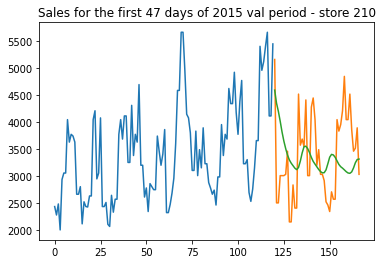

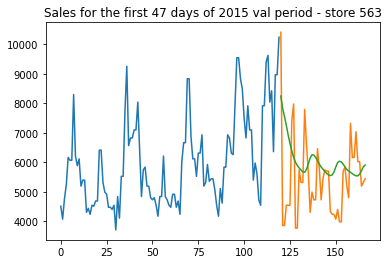

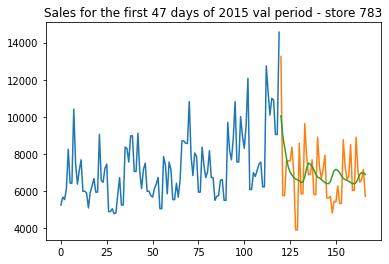

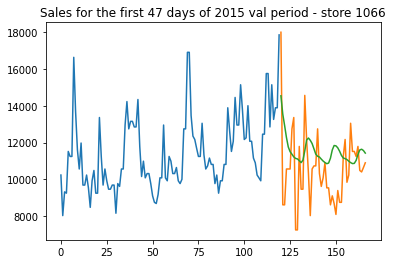

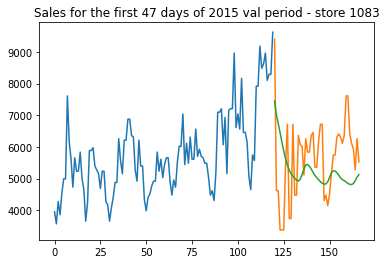

In [ ]:
for store in np.random.choice(valid_rescaled['Store'].unique(), size=5):
    row = valid_rescaled[valid_rescaled['Store'] == store][['X', 'Y', 'predictions', 'Date', 'Store']].iloc[-10]
    plt.plot(range(120), row['X'])
    plt.plot(range(120, 167), row['Y'])
    plt.plot(range(120, 167), row['predictions'])
    plt.title(f"Sales for the first 47 days of 2015 val period - store {store}")
    plt.show()

In [ ]:
def generate_flat_df(sequence_data, predict_col='predictions', actual_col='Y'):
    flat_df = pd.DataFrame()
    for i, row in sequence_data.iterrows():
        row_df = pd.DataFrame()
        start_date = row['Date']
        row_df['Date'] = pd.date_range(start_date, periods=47).date.tolist()
        row_df['Store'] = row['Store']
        row_df['predictions'] = row[predict_col]
        if actual_col:
            row_df['Sales'] = row[actual_col]
        flat_df = pd.concat([flat_df, row_df], ignore_index=False)
    flat_df.index = range(len(flat_df))
    flat_df['Date'] = pd.to_datetime(flat_df['Date'])
    return flat_df

In [ ]:
if mode == 'val':
    valid_sequence_data_sample = valid_rescaled[valid_rescaled['Date'] == '2015-01-01']
    valid_predict_df = generate_flat_df(valid_sequence_data_sample)

In [ ]:
test_predict_df = generate_flat_df(test_rescaled, actual_col=None)

In [ ]:
test_predict_df

,Date,Store,predictions
0,2015-08-01,1,5135.030174
1,2015-08-02,1,4864.541805
2,2015-08-03,1,4662.185323
3,2015-08-04,1,4511.045240
4,2015-08-05,1,4570.116403
...,...,...,...
40227,2015-09-12,1115,6583.429926
40228,2015-09-13,1115,6486.665975
40229,2015-09-14,1115,6334.115146
40230,2015-09-15,1115,6073.253600


In [ ]:
def rmse(y_hat, y):
    return np.mean(np.sqrt(y_hat - y))

In [ ]:
rmse(valid_predict_df['predictions'],valid_predict_df['Sales'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


31.648955153302673

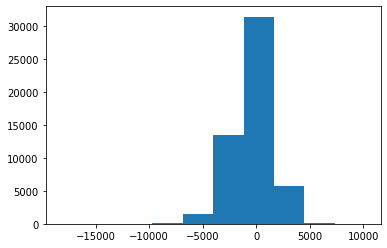

In [327]:
# residuals distribution (normal distribution of residuals)
plt.hist(valid_predict_df['predictions'] - valid_predict_df['Sales'])
plt.show()

In [ ]:
test_predict_df = test_predict_df.merge(test_df, on=['Date', 'Store'])

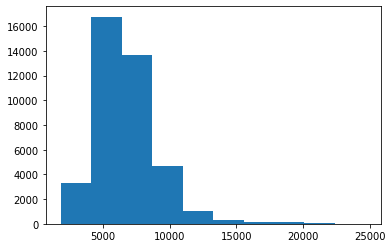

In [326]:
plt.hist(test_predict_df['predictions'])
plt.show()

In [328]:
test_predict_df.isna().sum()

Date                 0
Store                0
predictions          0
Id                   0
DayOfWeek            0
Open                 0
Promo                0
StateHoliday         0
SchoolHoliday        0
Sales            40232
Customers        40232
dtype: int64

In [329]:
test_predict_df.drop(['Sales', 'Customers'], axis=1, inplace=True)

In [332]:
test_predict_df.rename({'predictions': 'Sales'}, inplace=True, axis=1)

In [336]:
test_predict_df.to_csv('submission.csv')